In [1]:
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd

# Question 1

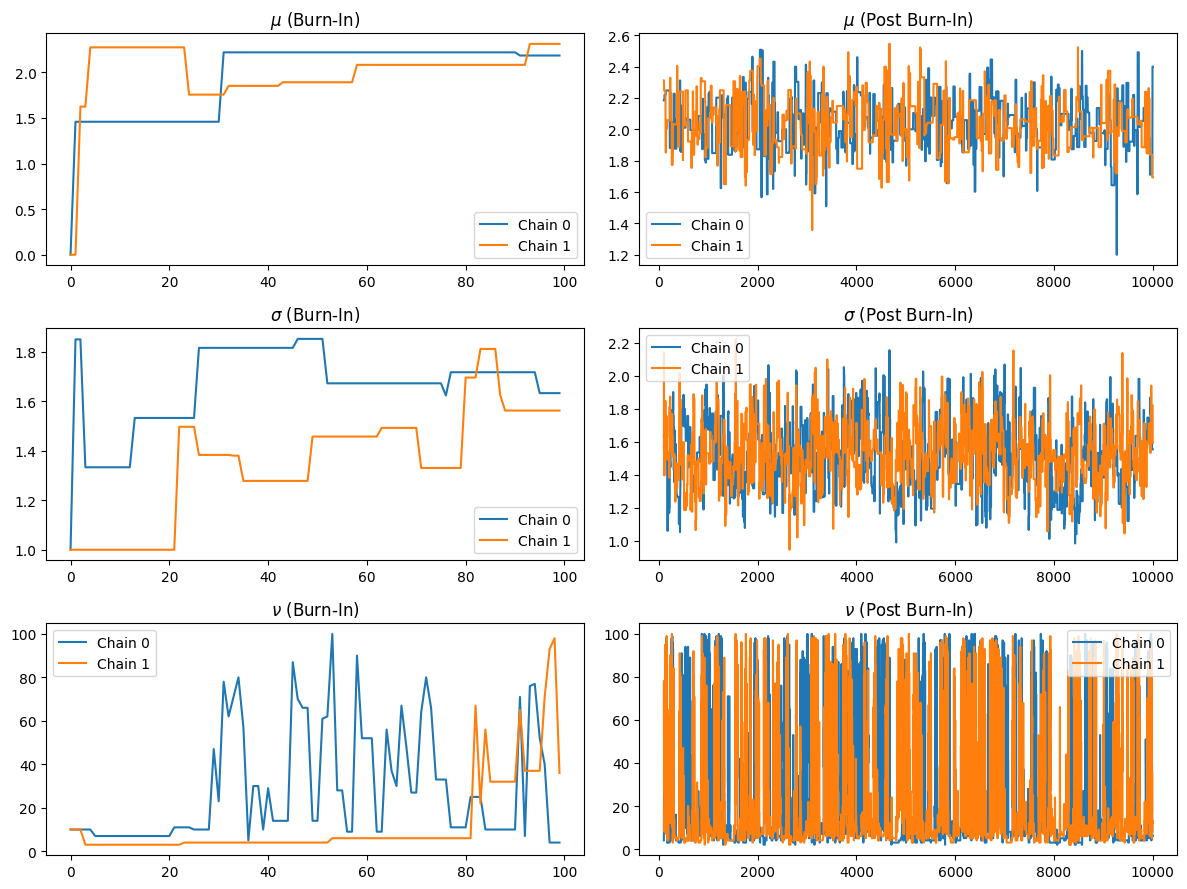

In [2]:
n = 100
mu_true = 2.0
sigma_true = 1.5
nu_true = 7

x = stats.t.rvs(df=nu_true, loc=mu_true, scale=sigma_true, size=n)

mu0 = 0.0
tau0 = 5.0
sigma0 = 3.0
nu_min, nu_max = 1, 100

C = 2
G = 10000
burn_in = 100

mu_chain    = np.zeros((C, G))
sigma_chain = np.zeros((C, G))
nu_chain    = np.zeros((C, G), dtype=int)

mu_chain[:, 0] = 0.0
sigma_chain[:, 0] = 1.0
nu_chain[:, 0] = 10

accept_mu = 0
accept_sigma = 0
accept_nu = 0

def mu_target(mu_, sigma_, nu_):
    if not (nu_min <= nu_ <= nu_max):
        return 0.0
    ll = np.sum(stats.t.logpdf(x, df=nu_, loc=mu_, scale=sigma_))
    lp = stats.norm(mu0, tau0).logpdf(mu_)
    return ll + lp

def sigma_target(sigma_, mu_, nu_):
    if sigma_ <= 0 or not (nu_min <= nu_ <= nu_max):
        return 0.0
    ll = np.sum(stats.t.logpdf(x, df=nu_, loc=mu_, scale=sigma_))
    lp = stats.halfnorm(scale=sigma0).logpdf(sigma_)
    return ll + lp

def nu_target(nu_, mu_, sigma_):
    # If nu_ is not in [1..100], prior is 0 => target=0
    if nu_ < nu_min or nu_ > nu_max:
        return 0.0
    ll = np.sum(stats.t.logpdf(x, df=nu_, loc=mu_, scale=sigma_))
    lp = np.log(1.0 / (nu_max - nu_min + 1))  # discrete uniform prior
    return ll + lp

for c in range(C):
    for g in range(1, G):

        mu_old    = mu_chain[c, g-1]
        sigma_old = sigma_chain[c, g-1]
        nu_old    = nu_chain[c, g-1]

        # proposal for mu
        mu_proposal_dist = stats.norm(loc=mu0, scale=tau0)
        mu_tilde = mu_proposal_dist.rvs()

        numerator   = mu_target(mu_tilde, sigma_old, nu_old) + mu_proposal_dist.logpdf(mu_old)
        denominator = mu_target(mu_old, sigma_old, nu_old) + mu_proposal_dist.logpdf(mu_tilde)
        mh_ratio_mu = numerator - denominator
        if np.log(np.random.rand()) < min(1.0, mh_ratio_mu):
            mu_chain[c, g] = mu_tilde
            accept_mu += 1
        else:
            mu_chain[c, g] = mu_old

        # proposal for sigma
        sigma_proposal_dist = stats.halfnorm(scale=sigma0)
        sigma_tilde = sigma_proposal_dist.rvs()

        numerator   = sigma_target(sigma_tilde, mu_chain[c, g], nu_old) + sigma_proposal_dist.logpdf(sigma_old)
        denominator = sigma_target(sigma_old, mu_chain[c, g], nu_old) + sigma_proposal_dist.logpdf(sigma_tilde)
        mh_ratio_sigma = numerator - denominator

        if np.log(np.random.rand()) < min(1.0, mh_ratio_sigma):
            sigma_chain[c, g] = sigma_tilde
            accept_sigma += 1
        else:
            sigma_chain[c, g] = sigma_old

        # proposal for nu?
        nu_proposal = np.random.randint(nu_min, nu_max+1)

        numerator   = nu_target(nu_proposal, mu_chain[c, g], sigma_chain[c, g]) + np.log((1.0 / (nu_max - nu_min + 1)))
        denominator = nu_target(nu_old, mu_chain[c, g], sigma_chain[c, g]) + np.log((1.0 / (nu_max - nu_min + 1)))
        mh_ratio_nu = numerator - denominator

        if np.log(np.random.rand()) < min(1.0, mh_ratio_nu):
            nu_chain[c, g] = nu_proposal
            accept_nu += 1
        else:
            nu_chain[c, g] = nu_old


for c in range(C):
    mu_pre     = mu_chain[c, :burn_in]
    sigma_pre  = sigma_chain[c, :burn_in]
    nu_pre     = nu_chain[c, :burn_in]

    mu_post     = mu_chain[c, burn_in:]
    sigma_post  = sigma_chain[c, burn_in:]
    nu_post     = nu_chain[c, burn_in:]

fig, ax = plt.subplots(3, 2, figsize=(12, 9))

ax[0,0].set_title(r"$\mu$ (Burn-In)")
ax[0,1].set_title(r"$\mu$ (Post Burn-In)")
ax[1,0].set_title(r"$\sigma$ (Burn-In)")
ax[1,1].set_title(r"$\sigma$ (Post Burn-In)")
ax[2,0].set_title(r"$\nu$ (Burn-In)")
ax[2,1].set_title(r"$\nu$ (Post Burn-In)")

for c in range(C):
    ax[0,0].plot(mu_chain[c, :burn_in], label=f"Chain {c}")
    ax[0,1].plot(np.arange(burn_in, G), mu_chain[c, burn_in:], label=f"Chain {c}")

    ax[1,0].plot(sigma_chain[c, :burn_in], label=f"Chain {c}")
    ax[1,1].plot(np.arange(burn_in, G), sigma_chain[c, burn_in:], label=f"Chain {c}")

    ax[2,0].plot(nu_chain[c, :burn_in], label=f"Chain {c}")
    ax[2,1].plot(np.arange(burn_in, G), nu_chain[c, burn_in:], label=f"Chain {c}")

for row in range(3):
    ax[row,0].legend()
    ax[row,1].legend()

plt.tight_layout()
plt.show()

# Question 2

In [3]:
sample_sizes = [50, 100, 500, 1000]

posterior_results = {}

for n in sample_sizes:
    x = stats.t.rvs(df=nu_true, loc=mu_true, scale=sigma_true, size=n)

    with pm.Model() as model:
        # Priors
        mu = pm.Normal("mu", mu=0.0, sigma=5.0)
        sigma = pm.HalfNormal("sigma", sigma=3.0)
        nu = pm.DiscreteUniform("nu", lower=1, upper=100)

        # Likelihood
        likelihood = pm.StudentT("obs", nu=nu, mu=mu, sigma=sigma, observed=x)

        # Sampling
        trace = pm.sample(3000, tune=1000, return_inferencedata=True, cores=2)

    posterior_results[n] = trace

Output()

Output()

Output()

Output()

In [4]:
for n, trace in posterior_results.items():
    print(f"Sample Size: {n}")
    print(az.summary(trace, var_names=["mu", "sigma", "nu"]))
    print("\n")


Sample Size: 50
         mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu      2.062   0.342   1.461    2.756      0.004    0.003    5881.0   
sigma   2.320   0.261   1.831    2.797      0.005    0.003    2776.0   
nu     53.005  27.821   6.000   96.000      0.881    0.623     915.0   

       ess_tail  r_hat  
mu       3820.0    1.0  
sigma    2843.0    1.0  
nu        797.0    1.0  


Sample Size: 100
         mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu      2.097   0.184   1.746    2.439      0.002    0.002    6386.0   
sigma   1.800   0.134   1.547    2.049      0.002    0.001    4910.0   
nu     59.518  25.790  15.000   98.000      0.677    0.479    1409.0   

       ess_tail  r_hat  
mu       4665.0    1.0  
sigma    3743.0    1.0  
nu       1310.0    1.0  


Sample Size: 500
         mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu      2.096   0.075   1.951    2.238      0.001    0.001    3016.0   
sigma   1.619   0.087   

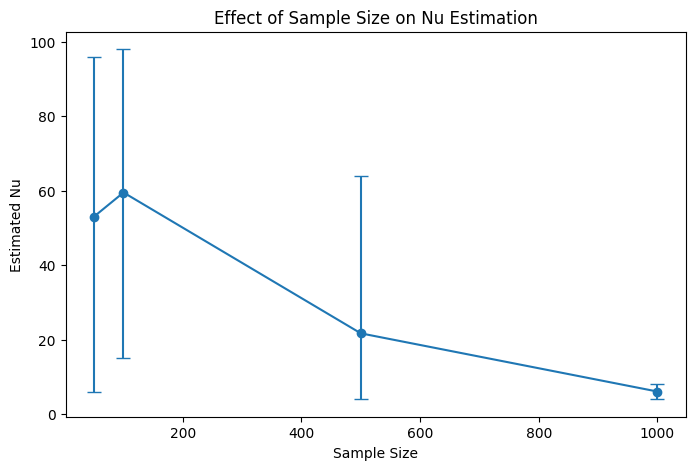

In [5]:
summary_df = []

for n, trace in posterior_results.items():
    stats = az.summary(trace, var_names=["nu"])
    mean_nu = stats.loc["nu", "mean"]
    hdi_3 = stats.loc["nu", "hdi_3%"]
    hdi_97 = stats.loc["nu", "hdi_97%"]
    summary_df.append([n, mean_nu, hdi_3, hdi_97])

summary_df = pd.DataFrame(summary_df, columns=["Sample Size", "Mean Nu", "3% HDI", "97% HDI"])

plt.figure(figsize=(8, 5))
plt.errorbar(summary_df["Sample Size"], summary_df["Mean Nu"],
             yerr=[summary_df["Mean Nu"] - summary_df["3% HDI"],
                   summary_df["97% HDI"] - summary_df["Mean Nu"]],
             fmt="o-", capsize=5)
plt.xlabel("Sample Size")
plt.ylabel("Estimated Nu")
plt.title("Effect of Sample Size on Nu Estimation")
plt.show()


The plot illustrates how the estimated degrees of freedom (v) parameter changes with sample size in the model. At smaller sample size, the estimate for v is highly uncertain as you can see with wide credible intervals. As sample size increases, the estimated v converges toward a true value with narrower credible inverval. This suggests that larger sample size provides more stable and reliable inference for v.

# Question 3

#### Prior on precision and likelihood:
$$\begin{aligned}
\tau_i &\sim \text{Gamma}(\alpha=v/2, \beta = v/2)
\\ \implies p(\tau_i) &= \frac{(v/2)^{v/2}}{\Gamma(v/2)}\tau_i^{v/2 - 1}\exp\{-v\tau_i/2\}
\\ y_i|\tau_i &\sim N(0,\tau_i)
\\ \implies p(y_i|\tau_i) &= \sqrt{\frac{\tau_i}{2\pi}}\exp\{-\tau_iy_i^2/2\}
\end{aligned}$$
We know that:
$$\begin{aligned}
p(y_i) &= \int_{0}^{\infty}p(y_i|\tau_i)p(\tau_i)d\tau_i
\\ &= \int_{0}^{\infty} \left[\sqrt{\frac{\tau_i}{2\pi}}\exp\{-\tau_iy_i^2/2\} \right]\left[\frac{(v/2)^{v/2}}{\Gamma(v/2)}\tau_i^{v/2 - 1}\exp\{-v\tau_i/2\} \right]d\tau_i
\\ &= \frac{(v/2)^{v/2}}{\Gamma(v/2)\cdot\sqrt{2\pi}}\int_{0}^{\infty}\tau_i^{(v-1)/2}\exp\{-\frac{\tau_i}{2}(v+y_i^2)\}d\tau_i
\end{aligned}$$

Using Gamma intergral: $\int_{0}^{\infty}x^{a-1}e^{-bx}dx = \frac{\Gamma(a)}{b^a}$

Let $a = (v+1)/2, b = \frac{v+y_i^2}{2}$

Now substituting back to the equation:

$$\begin{aligned}
\int_{0}^{\infty}\tau_i^{(v-1)/2}\exp\{-\frac{\tau_i}{2}(v+y_i^2)\}d\tau_i   &= \frac{\Gamma((v+1)/2)}{\left(\frac{v+y_i^2}{2}\right)^{(v+1)/2}}
\\ p(y_i) &= \frac{(v/2)^{v/2}}{\Gamma(v/2)\cdot\sqrt{2\pi}} \cdot \frac{\Gamma((v+1)/2)}{\left(\frac{v+y_i^2}{2}\right)^{(v+1)/2}}
\\ &= \frac{\Gamma\left(\frac{v+1}{2}\right)}{\sqrt{\pi v}\Gamma\left(v/2\right)}\left(1 + \frac{y_i^2}{v}\right)^{-\frac{v+1}{2}}
\\ \implies y_i &\sim t_v(0,1)
\end{aligned}$$


The behavior demonstrated here mirrors that of the posterior predictive distribution because both integrate over parameter uncertainty rather than assuming fixed values. By marginalizing over the latent precision parameter $\tau_i$, the distribution for $y_i$ becomes student's t-distribution, which shows the increased variance uncertainty.

Similarly, posterior predictive distributions account for parameter uncertainty, leading to more flexible predictions that better capture uncertainty in real-world data.